# Atmospheric River Map

 http://vortex.plymouth.edu/~j_cordeira/ARPortal/EU/Archive/2016121006/html/D1_IVT_0.html#tab
 The integrated vapor transport defines an AR. The region should be continous and $\ge$ 2000 km. The IVT $\ge$ 250 kg m$^{-1}$ s$^{-1}$.

http://journals.ametsoc.org/doi/abs/10.1175/MWR-D-13-00168.1
$$IVT = \frac{1}{g}\int_{p_sfc}^{100\,hPa} q \bf{V} dp$$


 http://apps.ecmwf.int/codes/grib/param-db
 #### Parameters from ECMWF
    - name = 'specific humidity',          shortName = 'q',     [kg kg^-1]
    - name = 'U component of wind',        shortName = 'u',      [m s^-1]
    - name = 'V component of wind',        shortName = 'v',      [m s^-1]



In [127]:
import pygrib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import math
from datetime import date
import calendar
import numpy as np
%matplotlib inline

### Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html

In [128]:
year = '2016'
mon = '12'
day = '10'
time = '00'

In [129]:
### Define colorbar colors
champ = 255.
# tot. precipitable water (grey scale)
no1 = np.array([255,255,255])/champ
no2 = np.array([250,255,0])/champ
no3 = np.array([255,203,0])/champ
no4 = np.array([255,121,0])/champ
no5 = np.array([255,0,0])/champ
no6 = np.array([148,0,97])/champ
no7 = np.array([101,0,137])/champ

no8 = np.array([130,102,0])/champ



In [130]:
def opengrib(yyyy, mm, dd, tt, pm, path):
    grib = '%s/%s/param_%s_%s%s%s_%s00.grib' % (path,pm,pm,yyyy,mm,dd,tt)
    grbs = pygrib.open(grib)
    return(grbs);

In [131]:
def selectgrb(grbs, sN, tOL, lv):
    val = grbs.select()[0]
    val = grbs.select(shortName = sN, typeOfLevel = tOL, level = lv)[0]
    val = val.values
    return(val);

In [132]:
def shiftgrb(grb,val):
    lat,lon = grb.latlons()
    lons = lon[0,:]
    val,lons = shiftgrid(180., val, lons, start = False)
    lats = lat[:,0]
    
    lons,lats = np.meshgrid(lons,lats)
    plons,plats = m(lons,lats)
    return(plons,plats,lons,lats,val);

In [133]:
# use only every 20, 35 value from the wind
### Wind
def windsel(lonsU,latsU,wind_u,wind_v):
    lonsUV = lonsU[0,:]
    latsUV = latsU[:,0]
    
    UVlats = np.empty((64,),dtype=float)
    UVlons = np.empty((74,),dtype=float)
    
    u_wind = np.empty((64,2560),dtype = float)
    u_wind[:] = np.NAN

    v_wind = np.empty((64,2560),dtype = float)
    v_wind[:] = np.NAN

    u_wind2 = np.empty((64,74),dtype = float)
    u_wind2[:] = np.NAN

    v_wind2 = np.empty((64,74),dtype = float)
    v_wind2[:] = np.NAN

    for i in range(0,64):
        UVlats[i] = latsUV[i*20]
        u_wind[i,:] = wind_u[i*20,:]
        v_wind[i,:] = wind_v[i*20,:]
    
    for k in range(0,74):
        UVlons[k] = lonsUV[k*35]
        u_wind2[:,k] = u_wind[:,k*35]
        v_wind2[:,k] = v_wind[:,k*35]
        
    UVlons,UVlats = np.meshgrid(UVlons,UVlats)
    plonsUV,platsUV = m(UVlons,UVlats)
    return(plonsUV,platsUV,u_wind2,v_wind2);

In [134]:
def totalwind(wind_u, wind_v):
    V = np.sqrt(wind_u**2 + wind_v**2)
    theta = (180./math.pi)*np.arctan2(-wind_u,-wind_v)    # meteorological wind direction, [deg]
    return(V,theta);

In [135]:
### OPEN FILES
path = '../test_dataECMWF/SCA/pl'

### PT
parameter = 'q'
grbsSH = opengrib(yyyy = year, mm = mon, dd = day, tt = time, pm = parameter, path = path)

### Wind
parameter = 'uv'
grbsUV = opengrib(yyyy = year, mm = mon, dd = day, tt = time, pm = parameter, path = path)


In [136]:
### Dates for plotting
yr = int(year)
mo = int(mon)
dy = int(day)
my_date = date(yr,mo,dy)
calday = calendar.day_name[my_date.weekday()]
calmon = calendar.month_abbr[mo]

In [137]:
### get the file values into python
# find the first grib message with a matching name:
grbSH = grbsSH.select()[0]
grbUV = grbsUV.select()[0]
## specific humidity
# from Rutz et al. - 2014:
# The integration is done using data at the surface, 50-hPa intervals from the surface to 500 hPa,

# specific humidity q
SH = dict()

# Wind
wind_u = dict()       # U component of wind
wind_v = dict()       # V component of wind
V = dict()            # total wind vector
theta = dict()        # wind direction

for i in range(750,1000,50):       # ECMWF has only levels 1000-850 in 50hPa
    lv = i + 50
    SH[lv] = selectgrb(grbsSH, 'q', 'isobaricInhPa', lv) 
    wind_u[lv] = selectgrb(grbsUV, 'u', 'isobaricInhPa', lv)
    wind_v[lv] = selectgrb(grbsUV, 'v', 'isobaricInhPa', lv)
    V[lv], theta[lv] = totalwind(wind_u[lv],wind_v[lv])
    
for i in range(100,800,100):       # ECMWF has from 700 - 100 hPa only in 100hPa steps
    lv = i
    SH[lv] = selectgrb(grbsSH, 'q', 'isobaricInhPa', lv)
    wind_u[lv] = selectgrb(grbsUV, 'u', 'isobaricInhPa', lv)
    wind_v[lv] = selectgrb(grbsUV, 'v', 'isobaricInhPa', lv)
    V[lv], theta[lv] = totalwind(wind_u[lv],wind_v[lv])

In [138]:
## calculate the IVT
g = 9.81      # gravitational acceleration [m s^-2]


IVT = (1/g)*((SH[100]*V[100])*10000 + \
            (SH[200]*V[200])*10000 + \
            (SH[300]*V[300])*10000 + \
            (SH[400]*V[400])*10000 + \
            (SH[500]*V[500])*10000 + \
            (SH[600]*V[600])*10000 + \
            (SH[700]*V[700])*10000 + \
            (SH[800]*V[800])*10000 + \
            (SH[850]*V[850])*5000 + \
            (SH[900]*V[900])*5000 + \
            (SH[950]*V[950])*5000 +\
            (SH[1000]*V[1000])*5000
            )


In [139]:
# Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html
m = Basemap(projection='merc', \
            llcrnrlon=-80., urcrnrlon=50., \
            llcrnrlat=15.,urcrnrlat=75., \
            resolution='l')

In [140]:
### Latitudes, Longitudes and shiftgrid
plonsIVT,platsIVT,lonsIVT,latsIVT, IVT = shiftgrb(grbUV,IVT)



In [141]:
# calculate IVT components
x_IVT = dict()
y_IVT = dict()
for i in range(750,1000,50):       # ECMWF has only levels 1000-850 in 50hPa
    lv = i + 50
    x_IVT[lv] =  -abs(IVT)* np.sin((math.pi/180)*theta[lv])
    y_IVT[lv] =  -abs(IVT)* np.cos((math.pi/180)*theta[lv])

    
for i in range(100,800,100):       # ECMWF has from 700 - 100 hPa only in 100hPa steps
    lv = i
    x_IVT[lv] =  -abs(IVT)* np.sin((math.pi/180)*theta[lv])
    y_IVT[lv] =  -abs(IVT)* np.cos((math.pi/180)*theta[lv])

IVT_u = (x_IVT[100] +  x_IVT[200] + x_IVT[300] + x_IVT[400] + x_IVT[500] + \
        x_IVT[600] + x_IVT[700] + x_IVT[800] + x_IVT[850] + \
        x_IVT[900] + x_IVT[950] + x_IVT[1000] )

IVT_v = (y_IVT[100] +  y_IVT[200] + y_IVT[300] + y_IVT[400] + y_IVT[500] + \
        y_IVT[600] + y_IVT[700] + y_IVT[800] + y_IVT[850] + \
        y_IVT[900] + y_IVT[950] + y_IVT[1000])





In [142]:
### IVT flux arrows
# use only every 20, 35 value from the IVT components
plonsUV_IVT,platsUV_IVT,u_IVT,v_IVT = windsel(lonsIVT,latsIVT,IVT_u,IVT_v)



In [216]:
x = np.arange(0,2560)
y = np.arange(0,1280)

res_lon = np.empty((2000,1713),dtype = float)
res_lon[:] = np.NAN

#for k in range(0,1280):
 #   idx =[j for (i,j) in zip(IVT[k,:],x) if i => 250. ]
  #  res_lon[k,:] = lonsIVT[:,idx]


lonrange = [j for (i,j) in zip(lonsIVT[0,:],x) if  -90<= i <= 61.]
#lonsIVT[0,lonrange[-1]]
latrange = [j for (i,j) in zip(latsIVT[:,0],y) if  i >= 0. ]
#print(latsIVT[latrange[-1],0])

new_lon = lonsIVT[:,lonrange[:]]   # x
new_lat = latsIVT[latrange[:],:]   # y
print(lonrange)

x[lonrange[:]].shape
#y2 = y[latrange[:]].size


#for k in range(0,y[latrange[:]].size):
 #   idx = [j for (i,j) in zip(IVT[,:],x) if i >= 250. ]  # 40°N
#IVT[354,idx]

[641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840,

(1073,)

In [143]:
### Dates for plotting
yr = int(year)
mo = int(mon)
dy = int(day)
my_date = date(yr,mo,dy)
calday = calendar.day_name[my_date.weekday()]
calmon = calendar.month_abbr[mo]



### Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html




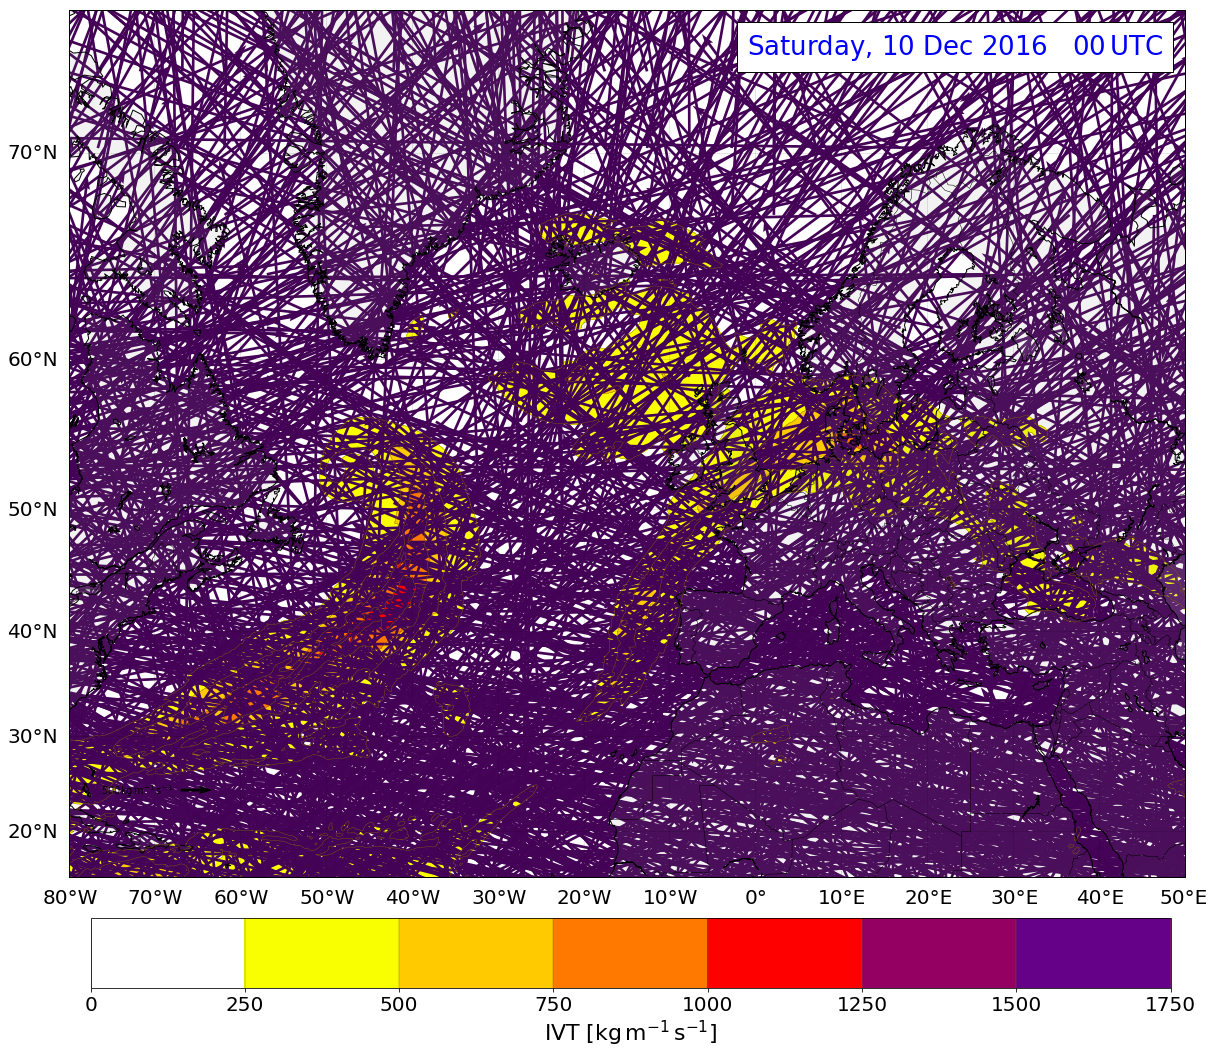

In [144]:

### PLOT FIGURE
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(1,1,1)
#
### Draw Latitude Lines
m.drawparallels(np.arange(-90.,120.,10.),labels=[1,0,0,0],fontsize=20,linewidth=0.2)
#
### Draw Longitude Lines
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0,0,0,1],fontsize=20,linewidth=0.2)
#
### Draw Map
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
m.fillcontinents(color='grey',alpha=0.1)


##
#
### Plot contour lines for IVT and fill
IVTlevels = np.arange(0,1900,250)
IVTmap = colors.ListedColormap([no1, no2, no3, no4, no5, no6, no7])
norm = colors.BoundaryNorm(boundaries = IVTlevels, ncolors=IVTmap.N)
#cs = m.contourf(plonsUV, platsUV, IVT, IVTlevels, norm = norm, cmap=IVTmap)
cs = m.contourf(plonsIVT, platsIVT, IVT, IVTlevels, norm = norm, cmap=IVTmap)


CS2 = plt.contour(cs, levels=cs.levels,
                  linewidths=0.4,
                  colors=[no8])

# Add arrows to show the IVT vectors
Q = m.quiver(plonsUV_IVT,platsUV_IVT,u_IVT,v_IVT,IVT)
# make quiver key
qk = plt.quiverkey(Q, 0.1, 0.1, 20, '500kg$\,$m$^{-1}\,$s$^{-1}$', labelpos = 'W')


#
### Add Colorbar
cbaxes = fig.add_axes([0.14, 0.03, .75, .06] )   #[left, bottom, width, height] 
cbar = plt.colorbar(cs,orientation='horizontal',cax = cbaxes)#, cax = cbaxes)#, shrink=0.5)
cbar.ax.set_xlabel('IVT [kg$\,$m$^{-1}\,$s$^{-1}$]',fontsize='22')
cbar.ax.tick_params(labelsize=20) 
# Make a colorbar for the ContourSet returned by the contourf call.
# Add the contour line levels to the colorbar
cbar.add_lines(CS2)

#cbar.ax.set_aspect(200)


#
### Add Textbox
ax.text(0.98,0.94, '%s, %s %s %s   %s$\,$UTC' %(calday, day, calmon, year, time),     # x, y
            verticalalignment = 'bottom',  horizontalalignment='right',
            transform = ax.transAxes,
            color ='blue', fontsize=26,
            bbox={'facecolor':'white','alpha':1., 'pad':10})
#
### Add Title
#fig.suptitle('Integrated Vapor Transport', fontsize=20, fontweight='bold') 
#ax.set_title('MSLP (solid contours every 4$\,$hPa), \n 250$\,$hPa wind speed (m$\,$s$^{-1}$, shaded according to the color bar), \n 1000-500$\,$hPa thickness (dashed contours every 6 dam), \n total precipitable water (mm, shaded according to gray scale)',             fontsize=13)

### Save
#plt.savefig('../synoptic_figs/Atm_Riv/%s%s%s_%s.png' % (year, mon, day,time))
## with header
#plt.savefig('../synoptic_figs/Jet_Thick_SLP/%s%s%s_%s_header.png' % (year, mon, day,time))

plt.show()